# Projet 8 - Déployer un modèle dans le cloud

La "Fruits!" cherche à proposer des solutions innovantes pour la récolte des fruits.

La volonté de l’entreprise est de préserver la biodiversité des fruits en permettant des traitements spécifiques pour chaque espèce de fruits en développant des robots cueilleurs intelligents.
Votre start-up souhaite dans un premier temps se faire connaître en mettant à disposition du grand public une application mobile qui permettrait aux utilisateurs de prendre en photo un fruit et d'obtenir des informations sur ce fruit.<br>
Vous êtes donc chargé de développer dans un environnement Big Data une première chaîne de traitement des données qui comprendra le preprocessing et une étape de réduction de dimension.

## Sommaire :
* [Importation des librairies](#chapter1)
* [Ouvertures des images](#chapter2)

## Importation des librairies <a class="anchor" id="chapter1"></a>

In [1]:
#Importation des librairies de bases
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Image
import os
from PIL import Image

## Ouverture image <a class="anchor" id="chapter1"></a>

Dans cette section, on prend le lien "training" et le but est d'afficher une image de chaque dossier. On récupère le nom de chacun des sous dossiers qu'on met dans la variable image. Ensuite, on affiche les premières images de chacun de ses sous dossiers.

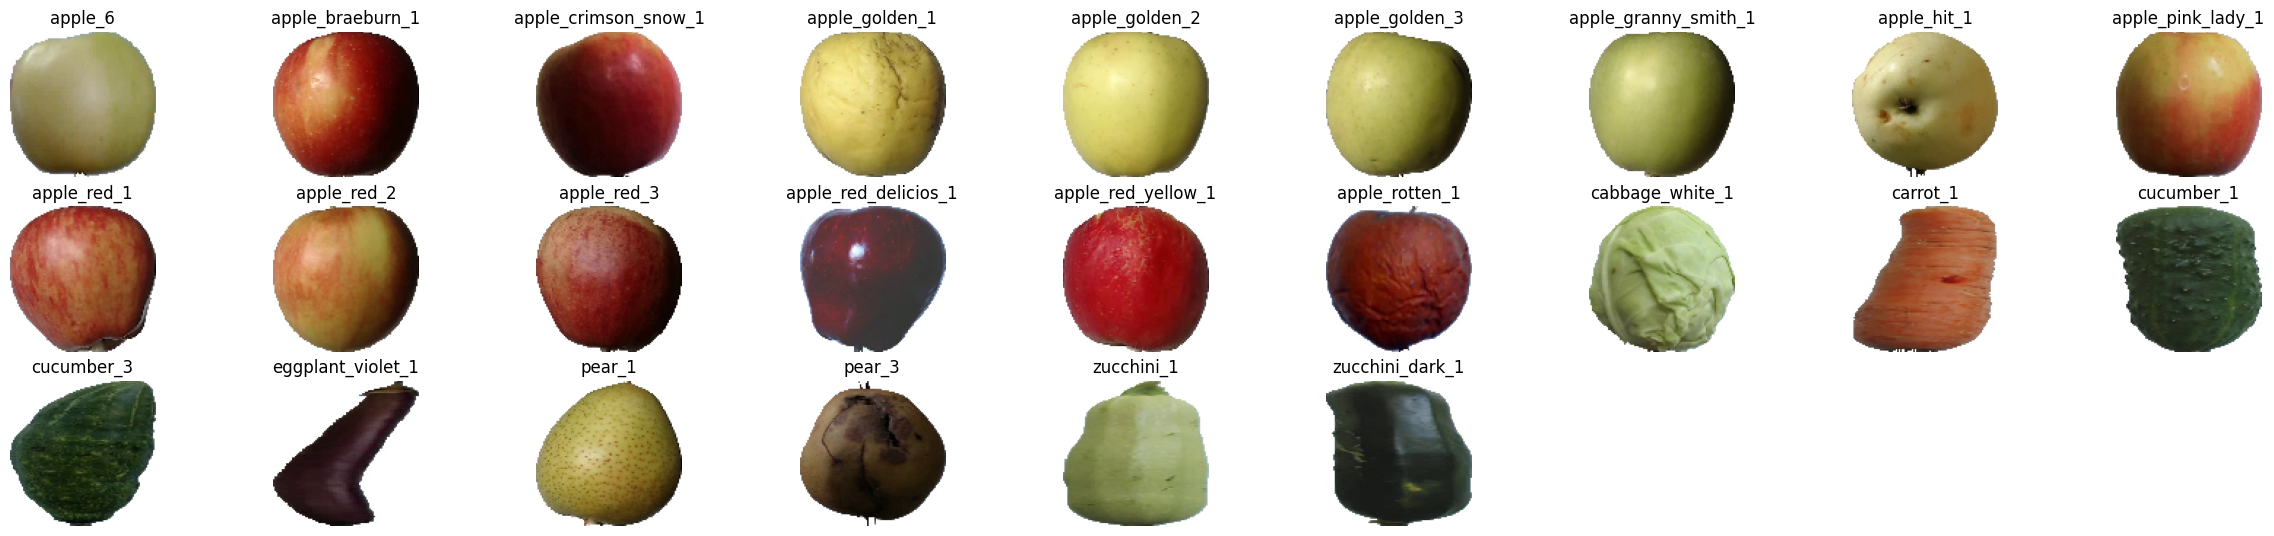

In [2]:
from tensorflow.keras.utils import img_to_array, load_img
# Le lien des images
path = "./archive/fruits-360-original-size/fruits-360-original-size/Training/"

# On récupère les noms de chacuns des sous-dossiers dans le fichier training.
# Pour un autre dossier, il suffit de changer de lien, tout est automatiser.
files = os.listdir(path)
images = []
for name in files:
    images.append(name)

# Les premières images de chaques sous dossier sont affiché, le noms est le même à chaque fois.
fig = plt.figure(figsize =(30,20))
for i in range(len(images)):
    ax = fig.add_subplot(9,9,i+1,xticks=[],yticks=[])
    plt.title(images[i])
    plt.axis("off")
    ax.imshow(load_img(path + images[i] +"/r0_0.jpg", target_size=(100,100)))

## PySpark

Dans cette section, on va travailler avec les images avec PySpark.

PySpark est une alternative plus puissante que Pandas Python. Il permet de faire des calculs en temps réel sur une grande quantité de données car il se concentre sur le traitement en mémoire. Il présente une faible latence.<br>
PySpark nous permet d’atteindre une grande vitesse de traitement des données, qui est environ 100 fois plus rapide en mémoire et 10 fois plus rapide sur le disque.

In [3]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import os

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession
from pyspark import SparkContext

In [4]:
PATH = os.getcwd()
PATH_Data = PATH+'/archive/fruits-360_dataset/fruits-360/Test/Apple Braeburn'
PATH_Result = PATH+'/archive/fruits-360_dataset/fruits-360/Training/Apple Braeburn'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

PATH:        c:\Users\lecou\Projet 8\Projet8
PATH_Data:   c:\Users\lecou\Projet 8\Projet8/archive/fruits-360_dataset/fruits-360/Test/Apple Braeburn
PATH_Result: c:\Users\lecou\Projet 8\Projet8/archive/fruits-360_dataset/fruits-360/Training/Apple Braeburn


In [5]:
import pyspark
from pyspark.sql import *
import findspark
findspark.init()

In [6]:
import os
import os
for o, v in sorted(os.environ.items()):
    if "SPARK" in o.upper():
        print("{0:25}= {1}".format(o, v.replace(os.environ["USERNAME"], "<username>")))

PYSPARK_PYTHON           = C:\Users\<username>\AppData\Local\Programs\Python\Python310\python.exe
SPARK_HOME               = C:\Spark\spark-3.3.1-bin-hadoop3


In [7]:
spark = SparkSession\
             .builder\
             .appName('P8')\
             .master('local')\
             .config("spark.sql.parquet.writeLegacyFormat", 'true')\
             .getOrCreate()

In [8]:
spark

In [9]:
sc = spark.sparkContext

In [10]:
images = spark.read.format("binaryFile") \
                    .option("pathGlobFilter", "*.jpg") \
                    .option("recursiveFileLookup", "true") \
                    .load(PATH_Data)

In [11]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+-------------------------------------------------------------------------------------------------------------+--------------+
|path                                                                                                         |label         |
+-------------------------------------------------------------------------------------------------------------+--------------+
|file:/c:/Users/lecou/Projet 8/Projet8/archive/fruits-360_dataset/fruits-360/Test/Apple Braeburn/r_326_100.jpg|Apple Braeburn|
|file:/c:/Users/lecou/Projet 8/Projet8/archive/fruits-360_dataset/fruits-360/Test/Apple Braeburn/r_4_100.jpg  |Apple Braeburn|
|file:/c:/Users/lecou/Projet 8/Projet8/archive/fruits-360_dataset/fruits-360/Test/Apple Braeburn/r_8_100.jpg  |Apple Braeburn|
|file:/c:/Users/lecou/Projet

In [12]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

In [13]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

In [14]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [15]:
brodcast_weights = sc.broadcast(new_model.get_weights())

In [16]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

In [17]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

c:\Users\lecou\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\pandas\functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [18]:
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

In [19]:
print(PATH_Result)

c:\Users\lecou\Projet 8\Projet8/archive/fruits-360_dataset/fruits-360/Training/Apple Braeburn


In [20]:
features_df.write.mode("overwrite").parquet(PATH_Result)

In [21]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')

In [22]:
df.head()

,path,label,features
0,file:/c:/Users/lecou/Projet 8/Projet8/archive/...,Apple Braeburn,"[0.0, 0.012291363, 0.0, 0.0, 0.0, 0.19167273, ..."
1,file:/c:/Users/lecou/Projet 8/Projet8/archive/...,Apple Braeburn,"[0.26330614, 0.22684966, 0.0, 0.0, 0.0, 0.5101..."
2,file:/c:/Users/lecou/Projet 8/Projet8/archive/...,Apple Braeburn,"[1.0492153, 0.15010254, 0.0, 0.0, 0.0, 0.78402..."
3,file:/c:/Users/lecou/Projet 8/Projet8/archive/...,Apple Braeburn,"[1.4807456, 0.0906174, 0.0, 0.0, 0.37914237, 0..."
4,file:/c:/Users/lecou/Projet 8/Projet8/archive/...,Apple Braeburn,"[0.89958906, 0.0011515617, 0.0, 0.0, 0.0, 0.75..."


In [23]:
df.loc[0,'features'].shape

(1280,)